In [28]:
import numpy as np
import torch
cuda = torch.device('cuda')
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from kernels import gaussian, matern
from pykeops.torch import LazyTensor
from _kernel_helpers import pdist_sym, pdist
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
__useTeX__ = True
if __useTeX__:
    plt.rcParams.update({
        "text.usetex": False,
        "mathtext.fontset": "cm",
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

### Load data

In [29]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print (f"    {key}: {val}")
chignolin_path = '../data/md_datasets/chignolin-unbiased/CLN025-0-protein-ALL.h5'
f = h5py.File(chignolin_path, 'r')
for key, val in f.attrs.items():
    print (f"{key}: {val}")
f.visititems(print_attrs)

CLASS: b'GROUP'
FILTERS: 65793
PYTABLES_FORMAT_VERSION: b'2.1'
TITLE: Empty(dtype=dtype('S1'))
VERSION: b'1.0'
application: b'MDTraj'
conventionVersion: b'1.1'
conventions: b'Pande'
program: b'MDTraj'
programVersion: b'1.9.5'
title: b'title'
cell_angles
    CLASS: b'EARRAY'
    EXTDIM: 0
    TITLE: Empty(dtype=dtype('S1'))
    VERSION: b'1.1'
    units: b'degrees'
cell_lengths
    CLASS: b'EARRAY'
    EXTDIM: 0
    TITLE: Empty(dtype=dtype('S1'))
    VERSION: b'1.1'
    units: b'nanometers'
coordinates
    CLASS: b'EARRAY'
    EXTDIM: 0
    TITLE: Empty(dtype=dtype('S1'))
    VERSION: b'1.1'
    units: b'nanometers'
topology
    CLASS: b'ARRAY'
    FLAVOR: b'python'
    TITLE: Empty(dtype=dtype('S1'))
    VERSION: b'2.4'


In [30]:
top_data = eval(f['topology'][0])['chains'][0]['residues']
heavy_atoms = []
for res in top_data:
    for atom in res['atoms']:
        if atom['element'] != 'H':
            heavy_atoms.append(atom['index'])
import itertools
pairs = []
for result in itertools.combinations(heavy_atoms, 2):
    pairs.append(result)
pairs = np.array(pairs)

In [31]:
pairs.shape

(4278, 2)

In [32]:
import mdtraj as md
traj = md.load_hdf5(chignolin_path)
distances = md.compute_distances(traj, pairs)

In [179]:
start = 100000
stop = 150000
num_steps = 5000
n_frames = len(traj)
stride = int((stop-start)/num_steps)
centers = distances[start:stop:stride,:]

In [180]:
centers.shape

(5000, 4278)

In [181]:
D = pdist_sym(centers, distances.dtype)
#Could be chosen more accurately
l = np.std(D)
print(l)

344.0423


In [182]:
K_all = matern(D, l=np.sqrt(l))

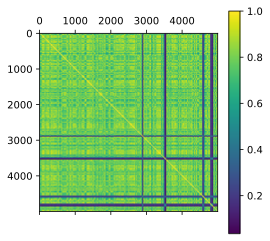

In [183]:
plt.matshow(K_all)
plt.colorbar()

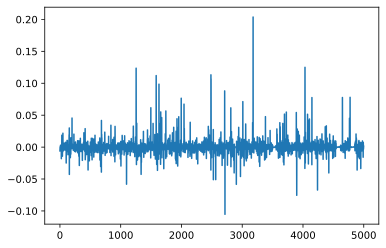

In [184]:
n = K_all.shape[0] - 1
K = K_all[:-1, :-1]
K_T = K_all[-1,:-1]
reg = 0
alpha = np.linalg.solve(K + reg*np.eye(n), K_T)
plt.plot(alpha)
S = np.zeros((n,n))
S[1:,:-1] = np.eye(n-1)
S[:,-1] = alpha

In [185]:
vals, R_vecs = np.linalg.eig(S)
logvals = np.log(vals)

In [186]:
L_vecs = np.vander(vals, increasing=True)
Id = L_vecs@R_vecs
zero_mat = Id - np.diag(np.diag(Id))
np.abs(zero_mat).max()

4.124464848221425e-09

Text(0, 0.5, '$\\rm{Im}\\, \\lambda$')

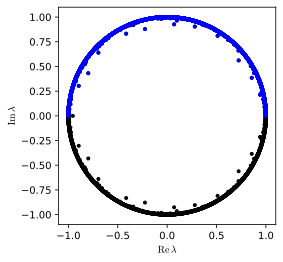

In [187]:
mask = (np.imag(vals) >= 1e-15)
figure, axes = plt.subplots()
#draw_circle = plt.Circle((0, 0), 1,fill=False, lw =0.5)
axes.set_aspect(1)
#axes.add_artist(draw_circle)
axes.plot(np.real(vals), np.imag(vals), 'k.')
axes.plot(np.real(vals[mask]), np.imag(vals[mask]), 'b.')
axes.set_xlabel(r'$\rm{Re}\, \lambda$')
axes.set_ylabel(r'$\rm{Im}\, \lambda$')

In [188]:
D_test = pdist(distances[::50], centers[:-1,:], distances.dtype)

In [193]:
sort_perm = np.argsort(np.abs(vals[mask]))
CVs = (matern(D_test, l=np.sqrt(l))@R_vecs[:, mask][:, sort_perm])*vals[mask][sort_perm]
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca_CVs = pca.fit_transform(np.real(CVs))

In [194]:
CVs.shape

(10495, 2498)

In [195]:
print(pca.explained_variance_ratio_)

[0.80243565 0.13399655 0.01673141 0.01038772 0.00819594]


In [192]:
from scipy.stats import gaussian_kde

In [44]:
import ipywidgets as widgets

In [196]:
def f(x):
    kde = gaussian_kde(pca_CVs[:,x], bw_method=0.2)
    bounds = (pca_CVs[:,x].min(),pca_CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 100)
    print(kde.factor)
    plt.plot(cv_sample, -kde.logpdf(cv_sample) )
    plt.margins(0)
widgets.interact(f, x=widgets.IntSlider(min=0, max=pca_CVs.shape[1] - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, descriptors_from_traj, sample
from stateinterpreter.plot import plot_states, plot_combination_states_features
from stateinterpreter.visualize import visualize_features

In [209]:
chignolin_data_path = '../data/md_datasets/chignolin-unbiased/'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
stride = 50
#Compute descriptors
descriptors, feats_info = descriptors_from_traj(traj_dict, descriptors=['dihedrals'], stride=stride)

Descriptors: (10495, 102)


In [199]:
import pandas as pd
col_names = [f"Kernel_DMD_{idx}" for idx in range(pca_CVs.shape[1])]
colvars = pd.DataFrame(pca_CVs, columns=col_names)

In [200]:
col_names

['Kernel_DMD_0',
 'Kernel_DMD_1',
 'Kernel_DMD_2',
 'Kernel_DMD_3',
 'Kernel_DMD_4']

In [201]:
cv_list = ["Kernel_DMD_0", "Kernel_DMD_1"]
kBT = 2.8
states_labels = identify_metastable_states(colvars, cv_list, kBT, bw_method=0.2, fes_cutoff=0.1*kBT, optimizer_kwargs={'num_init' : 200})

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 1309 configurations.
	Basin 1 -> 661 configurations.
	Basin 2 -> 612 configurations.
	Basin 3 -> 481 configurations.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


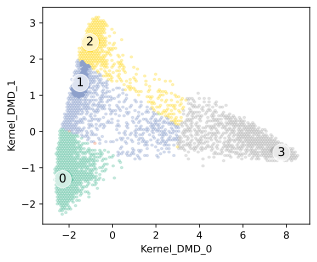

In [202]:
plot_states(colvars, states_labels, cv_list)

In [171]:
main_color = ['k', 'red', 'blue']
mask = states_labels['selection'].to_numpy()
colors = np.array([main_color[label] for label in states_labels['labels']])

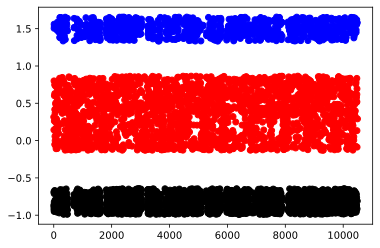

In [172]:
plt.scatter(np.arange(len(colors))[mask], colvars[cv_list[0]][mask], c=colors[mask])

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:00<00:00, 164.59it/s]


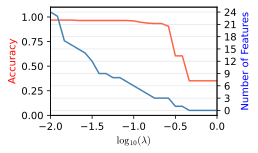

In [210]:
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 300, states_subset=[0,1,2])
regularizers = np.geomspace(0.01, 1, 25)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=False)

classifier.plot();

In [211]:
reg = 10**(-0.7)
classifier.print_selected(reg)

Accuracy: 93%
State 0:
[66.528%]  SIDECHAIN sin_chi1 TYR1
[33.472%]  BACKBONE sin_psi TYR1
State 1:
[97.188%]  BACKBONE sin_psi TYR1
[2.812% ]  SIDECHAIN cos_chi1 TYR1
State 2:
[86.605%]  SIDECHAIN cos_chi1 TYR1
[13.395%]  SIDECHAIN sin_chi1 TYR1


In [137]:
visualize_features(traj, states_labels, classifier.classes, classifier._get_selected(reg), feats_info)

NGLWidget(max_frame=1)